In [4]:
import pandas as pd 
import numpy as np
import os 
import re
import pickle
import json
import torch
from datetime import datetime
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LinearRegression
from scipy.stats import pearsonr 
pd.options.mode.chained_assignment = None

data_path = '/data/gusev/USERS/jpconnor/clinical_text_project/data/'
survival_data_path = data_path + 'survival_data/'
test_path = data_path + 'pca_metadata_association_tests/'

def run_continuous_association_test(meta_df, embedding_pcs, continuous_variables, num_pcs_to_test=50):
    X = meta_df[continuous_variables]
    embed_idx = X.index.tolist()

    num_vars = len(continuous_variables)

    betas_df = pd.DataFrame(np.zeros((num_pcs_to_test, num_vars)), columns=continuous_variables)
    scores_df = pd.DataFrame(np.zeros((num_pcs_to_test, num_vars)), columns=continuous_variables)

    for cont_var in continuous_variables:
        cur_X = X[cont_var].values.reshape(-1,1)
        for pc_idx in tqdm(list(range(num_pcs_to_test))):
            lin_model = LinearRegression().fit(cur_X, embedding_pcs[embed_idx, pc_idx])
            fit_score = lin_model.score(cur_X, embedding_pcs[embed_idx, pc_idx])

            betas_df.loc[pc_idx, cont_var] = lin_model.coef_
            scores_df.loc[pc_idx, cont_var] = fit_score

    betas_df.insert(0, 'PC_TESTED', range(len(betas_df.index)))
    melted_betas_df = betas_df.melt(id_vars=['PC_TESTED'], var_name='Variable', value_name='Beta_Coef')
    melted_betas_df['Abs(Beta_Coef)'] = np.abs(melted_betas_df['Beta_Coef'])
    
    scores_df.insert(0, 'PC_TESTED', range(len(scores_df.index)))
    melted_scores_df = scores_df.melt(id_vars=['PC_TESTED'], var_name='Variable', value_name='R_squared')
    
    return melted_betas_df, melted_scores_df

def run_discrete_association_test(meta_df, embedding_pcs, discrete_variables, discrete_cols, num_pcs_to_test=50):
    
    X = pd.get_dummies(meta_df[discrete_variables], columns=discrete_variables, drop_first=False)
    embed_idx = X.index.tolist()
    
    cat_col_map = {key : [] for key in discrete_variables}
    col_cat_map = dict()
    for col in X.columns:
        for col_name in discrete_cols:
            if col_name in col:
                col_cat_map[col] = col_name
                cat_col_map[col_name].append(col)

    betas_df = pd.DataFrame(np.zeros((num_pcs_to_test, len(X.columns))), columns=X.columns)
    scores_df = pd.DataFrame(np.zeros((num_pcs_to_test, len(discrete_variables))), columns=discrete_variables)

    for discrete_var in discrete_variables:
        cur_X = X[cat_col_map[discrete_var]]

        for pc_idx in tqdm(list(range(num_pcs_to_test))):
            lin_model = LinearRegression().fit(cur_X.values, embedding_pcs[embed_idx, pc_idx])
            fit_score = lin_model.score(cur_X.values, embedding_pcs[embed_idx, pc_idx])

            betas_df.loc[pc_idx, cat_col_map[discrete_var]] = lin_model.coef_
            scores_df.loc[pc_idx, discrete_var] = fit_score


    betas_df.insert(0, 'PC_TESTED', range(len(betas_df.index)))
    melted_betas_df = betas_df.melt(id_vars=['PC_TESTED'], var_name='Dummy_Variable', value_name='Beta_Coef')
    melted_betas_df.insert(1, 'Variable_Category', melted_betas_df['Dummy_Variable'].map(col_cat_map))
    melted_betas_df['Abs(Beta_Coef)'] = np.abs(melted_betas_df['Beta_Coef'])

    scores_df.insert(0, 'PC_TESTED', range(len(scores_df.index)))
    melted_scores_df = scores_df.melt(id_vars=['PC_TESTED'], var_name='Variable', value_name='R_squared')
    
    return melted_betas_df, melted_scores_df

In [2]:
embedding_meta = pd.read_csv(data_path + 'full_IO_embeddings_metadata_v2.csv')
just_embeddings = np.load(open(data_path + 'full_IO_embeddings_as_array_v2.npy', 'rb'))
full_events_df = pd.read_csv(survival_data_path + 'full_irAE_survival_data.csv')

/tmp/ipykernel_24559/1169755534.py:1: DtypeWarning: Columns (2,4,7,8,9,11,12,13,14,22,23,25,29,32,33,36,37,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  embedding_meta = pd.read_csv(data_path + 'full_IO_embeddings_metadata_v2.csv')


In [3]:
columns_to_keep = ['DFCI_MRN', 'NOTE_TYPE', 'PROC_DESC', 'PROVIDER_CRED', 'ENCOUNTER_TYPE_DESC', 'DATA_SOURCE', 'EMBEDDING_INDEX', 
                   'PX_CANCER_TYPE', 'PX_EVENT', 'NOTE_DATETIME', 'TRUNCATED_SEQ_LEN', 'NOTE_TIME_REL_IO_START']
embedding_meta = embedding_meta[columns_to_keep]
embedding_meta.loc[embedding_meta['PROC_DESC'] == 'Progress Note', 'PROC_DESC'] = np.nan

embedding_meta['NOTE_YEAR'] = embedding_meta['NOTE_DATETIME'].apply(lambda x : str(re.split('-', x)[0]))

### Association testing

In [ ]:
# test one vs rest for discrete labels
continuous_cols = ['TRUNCATED_SEQ_LEN', 'NOTE_TIME_REL_IO_START']
discrete_cols = ['NOTE_TYPE', 'NOTE_YEAR', 'PROC_DESC', 'PROVIDER_CRED', 'ENCOUNTER_TYPE_DESC', 'DATA_SOURCE', 'PX_CANCER_TYPE', 'PX_EVENT']

discrete_var_map_dict = dict()
discrete_pvalue_dict = dict()
discrete_delta_pc_dict = dict()

min_samples = 100

for col in discrete_cols:
    var_counts = embedding_meta[col].value_counts()
    vars_to_keep = var_counts[var_counts >= min_samples].index.tolist()
    vars_to_collapse = var_counts[var_counts < min_samples].index.tolist()

    if np.sum(embedding_meta[col].isna()) > 0:
        discrete_var_map_dict[col] = {np.nan : np.nan}
    else:
        discrete_var_map_dict[col] = dict()

    discrete_var_map_dict[col].update({var : var for var in vars_to_keep})
    discrete_var_map_dict[col].update({var : np.nan for var in vars_to_collapse})

for col in discrete_cols:
    embedding_meta[col] = embedding_meta[col].map(discrete_var_map_dict[col])

In [ ]:
embedding_pcs = PCA(n_components=50).fit_transform(just_embeddings)

clinical_discrete_cols = [col for col in discrete_cols if col not in ['PROC_DESC', 'DATA_SOURCE']]
clinical_meta = embedding_meta.loc[embedding_meta['NOTE_TYPE'] == 'Clinician'].reset_index()
clinical_pcs = PCA(n_components=50).fit_transform(just_embeddings[clinical_meta['EMBEDDING_INDEX'],:])

imaging_discrete_cols = [col for col in discrete_cols if col not in ['ENCOUNTER_TYPE_DESC', 'PROVIDER_CRED', 'DATA_SOURCE']]
imaging_meta = embedding_meta.loc[embedding_meta['NOTE_TYPE'] == 'Imaging'].reset_index()
imaging_pcs = PCA(n_components=50).fit_transform(just_embeddings[imaging_meta['EMBEDDING_INDEX'],:])

pathology_discrete_cols = imaging_discrete_cols
pathology_meta = embedding_meta.loc[embedding_meta['NOTE_TYPE'] == 'Pathology'].reset_index()
pathology_pcs = PCA(n_components=50).fit_transform(just_embeddings[pathology_meta['EMBEDDING_INDEX'],:])

In [ ]:
# test across all note types

continuous_betas_df, continuous_scores_df = run_continuous_association_test(embedding_meta, embedding_pcs, continuous_cols, num_pcs_to_test=50)
discrete_betas_df, discrete_scores_df = run_discrete_association_test(embedding_meta, embedding_pcs, discrete_cols, num_pcs_to_test=50)

continuous_betas_df.to_csv(test_path + 'continuous_all_notes_betas.csv')
continuous_scores_df.to_csv(test_path + 'continuous_all_notes_scores.csv')
discrete_betas_df.to_csv(test_path + 'discrete_all_notes_betas.csv')
discrete_scores_df.to_csv(test_path + 'discrete_all_notes_scores.csv')

# test within clinician only

continuous_clinical_betas, continuous_clinical_scores = run_continuous_association_test(clinical_meta, clinical_pcs, continuous_cols)
discrete_clinical_betas, discrete_clinical_scores = run_discrete_association_test(clinical_meta, clinical_pcs, clinical_discrete_cols)

continuous_clinical_betas.to_csv(test_path + 'continuous_clinical_betas.csv')
continuous_clinical_scores.to_csv(test_path + 'continuous_clinical_scores.csv')
discrete_clinical_betas.to_csv(test_path + 'discrete_clinical_betas.csv')
discrete_clinical_scores.to_csv(test_path + 'discrete_clinical_scores.csv')

# test within imaging only

continuous_imaging_betas, continuous_imaging_scores = run_continuous_association_test(imaging_meta, imaging_pcs, continuous_cols)
discrete_imaging_betas, discrete_imaging_scores = run_discrete_association_test(imaging_meta, imaging_pcs, imaging_discrete_cols)

continuous_imaging_betas.to_csv(test_path + 'continuous_imaging_betas.csv')
continuous_imaging_scores.to_csv(test_path + 'continuous_imaging_scores.csv')
discrete_imaging_betas.to_csv(test_path + 'discrete_imaging_betas.csv')
discrete_imaging_scores.to_csv(test_path + 'discrete_imaging_scores.csv')

# test within pathology only

continuous_pathology_betas, continuous_pathology_scores = run_continuous_association_test(pathology_meta, pathology_pcs, continuous_cols)
discrete_pathology_betas, discrete_pathology_scores = run_discrete_association_test(pathology_meta, pathology_pcs, pathology_discrete_cols)

continuous_pathology_betas.to_csv(test_path + 'continuous_pathology_betas.csv')
continuous_pathology_scores.to_csv(test_path + 'continuous_pathology_scores.csv')
discrete_pathology_betas.to_csv(test_path + 'discrete_pathology_betas.csv')
discrete_pathology_scores.to_csv(test_path + 'discrete_pathology_scores.csv')

In [ ]:
keys = ['all_notes', 'clinical', 'imaging', 'pathology']

continuous_results_dict = {'betas' : {key : pd.read_csv(test_path + 'continuous_' + key + '_betas.csv', index_col=0) for key in keys},
                        'scores' : {key : pd.read_csv(test_path + 'continuous_' + key + '_scores.csv', index_col=0) for key in keys}}


discrete_results_dict = {'betas' : {key : pd.read_csv(test_path + 'discrete_' + key + '_betas.csv', index_col=0) for key in keys},
                        'scores' : {key : pd.read_csv(test_path + 'discrete_' + key + '_scores.csv', index_col=0) for key in keys}}

In [ ]:
cont_results = continuous_results_dict['scores']['all_notes']
disc_results = discrete_results_dict['scores']['all_notes']

full_scores_df = round(pd.concat([cont_results, disc_results]).pivot(columns='Variable', index='PC_TESTED', values='R_squared').iloc[0:50], 3)

In [ ]:
plt.figure(figsize=(20,8))
ax = sns.heatmap(full_scores_df.reindex(full_scores_df.mean().sort_values(ascending=False).index, axis=1))
ax.set(title='R^2 for each (PC, Variable) regression (Across Note Types)')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

In [ ]:
cont_scores = continuous_results_dict['scores']['clinical']
disc_scores = discrete_results_dict['scores']['clinical']

full_clinical_scores_df = round(pd.concat([cont_scores, disc_scores]).pivot(columns='Variable', index='PC_TESTED', values='R_squared').iloc[0:50],3)

plt.figure(figsize=(20,8))
ax = sns.heatmap(full_clinical_scores_df.reindex(full_clinical_scores_df.mean().sort_values(ascending=False).index, axis=1))
ax.set(title='R^2 for each (PC, Variable) regression (Clinical Note Type)')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

In [ ]:
cont_scores = continuous_results_dict['scores']['imaging']
disc_scores = discrete_results_dict['scores']['imaging']

full_imaging_scores_df = round(pd.concat([cont_scores, disc_scores]).pivot(columns='Variable', index='PC_TESTED', values='R_squared').iloc[0:50],3)

plt.figure(figsize=(20,8))
ax = sns.heatmap(full_imaging_scores_df.reindex(full_imaging_scores_df.mean().sort_values(ascending=False).index, axis=1))
ax.set(title='R^2 for each (PC, Variable) regression (Imaging Note Type)')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

In [ ]:
cont_scores = continuous_results_dict['scores']['pathology']
disc_scores = discrete_results_dict['scores']['pathology']

full_imaging_scores_df = round(pd.concat([cont_scores, disc_scores]).pivot(columns='Variable', index='PC_TESTED', values='R_squared').iloc[0:50],3)

plt.figure(figsize=(20,8))
ax = sns.heatmap(full_imaging_scores_df.reindex(full_imaging_scores_df.mean().sort_values(ascending=False).index, axis=1))
ax.set(title='R^2 for each (PC, Variable) regression (Pathology Note Type)')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

### Year vs. Note Timing Analysis

In [ ]:
image_betas = discrete_results_dict['betas']['imaging']
path_betas = discrete_results_dict['betas']['pathology']

image_note_year_betas = image_betas.loc[(image_betas['PC_TESTED'] == 1) & 
                                        (image_betas['Variable_Category'] == 'NOTE_YEAR')]
path_note_year_betas = path_betas.loc[(path_betas['PC_TESTED'] == 1) &
                                      (path_betas['Variable_Category'] == 'NOTE_YEAR')]

image_note_year_betas['Year'] = image_note_year_betas['Dummy_Variable'].apply(lambda x : int(re.split('_', x)[2]))
path_note_year_betas['Year'] = path_note_year_betas['Dummy_Variable'].apply(lambda x : int(re.split('_', x)[2]))

plt.figure(figsize=(8,6))
sns.scatterplot(image_note_year_betas, x='Year', y='Beta_Coef').set(title='PC_1 Regression Betas for Year Dummy Variables (Imaging)')
plt.axvline(x=2015, color='red', label='2015'); plt.legend(loc='upper left')

plt.figure(figsize=(8,6))
sns.scatterplot(path_note_year_betas, x='Year', y='Beta_Coef').set(title='PC_1 Regression Betas for Year Dummy Variables (Pathology)')
plt.axvline(x=2015, color='red', label='2015'); plt.legend(loc='upper left')

In [ ]:
imaging_meta[['PC_0', 'PC_1']] = imaging_pcs[:,0:2]
pathology_meta[['PC_0', 'PC_1']] = pathology_pcs[:,0:2]

In [ ]:
sns.scatterplot(imaging_meta, x='PC_0', y='PC_1', hue='NOTE_YEAR')

In [ ]:
imaging_meta['NOTE_YEAR'].

In [ ]:
def categorize_year(year_value):
    try:
        if int(year_value) > 2015:
            return 'After 2015'
        elif int(year_value) == 2015:
            return 'During 2015'
        else:
            return 'Before 2015'
    except:
        return 'Invalid Year'

imaging_meta['Year_Category'] = imaging_meta['NOTE_YEAR'].apply(categorize_year)
pathology_meta['Year_Category'] = pathology_meta['NOTE_YEAR'].apply(categorize_year)

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(imaging_meta.loc[imaging_meta['Year_Category'] != 'Invalid Year'],
                x = 'PC_0', y='PC_1', hue='Year_Category', s=5, alpha=0.5).set(title='PCs of Imaging Note Embeddings by Year')

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(pathology_meta.loc[pathology_meta['Year_Category'] != 'Invalid Year'],
                x = 'PC_0', y='PC_1', hue='Year_Category', s=5, alpha=0.5).set(title='PCs of Pathology Note Embeddings by Year')

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(imaging_meta.loc[imaging_meta['Year_Category'] != 'Invalid Year'], x='Year_Category', y='NOTE_TIME_REL_IO_START', 
               order=['Before 2015', 'During 2015', 'After 2015']).set(title='Distribution of Note Times by Year Category (Imaging)')

plt.figure(figsize=(8,6))
sns.violinplot(pathology_meta.loc[pathology_meta['Year_Category'] != 'Invalid Year'], x='Year_Category', y='NOTE_TIME_REL_IO_START',
              order=['Before 2015', 'During 2015', 'After 2015']).set(title='Distribution of Note Times by Year Category (Pathology)')

### Within 2015 Analysis

In [13]:
def extract_year_month(datetime_val):
    split_str = re.split('-', datetime_val)
    return split_str[0] + '_' + split_str[1]

# embedding_sub = embedding_meta.loc[embedding_meta['NOTE_YEAR'].isin(['2014' ,'2015', '2016'])]
embedding_sub = embedding_meta

embedding_sub['NOTE_YEAR_MONTH'] = embedding_sub['NOTE_DATETIME'].apply(extract_year_month)
embedding_pcs = PCA(n_components=50).fit_transform(just_embeddings)

clinical_meta = embedding_sub.loc[embedding_sub['NOTE_TYPE'] == 'Clinician'].reset_index()
clinical_pcs = PCA(n_components=50).fit_transform(just_embeddings[clinical_meta['EMBEDDING_INDEX'],:])

imaging_meta = embedding_sub.loc[embedding_sub['NOTE_TYPE'] == 'Imaging'].reset_index()
imaging_pcs = PCA(n_components=50).fit_transform(just_embeddings[imaging_meta['EMBEDDING_INDEX'],:])

pathology_meta = embedding_sub.loc[embedding_sub['NOTE_TYPE'] == 'Pathology'].reset_index()
pathology_pcs = PCA(n_components=50).fit_transform(just_embeddings[pathology_meta['EMBEDDING_INDEX'],:])

In [14]:
all_betas, all_scores = run_discrete_association_test(embedding_sub, embedding_pcs, ['NOTE_YEAR_MONTH'], ['NOTE_YEAR_MONTH'], num_pcs_to_test=10)
clinical_betas, clinical_scores = run_discrete_association_test(clinical_meta, clinical_pcs, ['NOTE_YEAR_MONTH'], ['NOTE_YEAR_MONTH'], num_pcs_to_test=10)
image_betas, image_scores = run_discrete_association_test(imaging_meta, imaging_pcs, ['NOTE_YEAR_MONTH'], ['NOTE_YEAR_MONTH'], num_pcs_to_test=10)
path_betas, path_scores = run_discrete_association_test(pathology_meta, pathology_pcs, ['NOTE_YEAR_MONTH'], ['NOTE_YEAR_MONTH'], num_pcs_to_test=10)

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


In [26]:
image_betas['NOTE_YEAR'] = image_betas['Dummy_Variable'].apply(lambda x : int(re.split('_', x)[3]))
image_betas['NOTE_MONTH'] = image_betas['Dummy_Variable'].apply(lambda x : int(re.split('_', x)[4]))
image_betas.sort_values(by=['NOTE_YEAR', 'NOTE_MONTH'], ascending=[True, True], inplace=True)

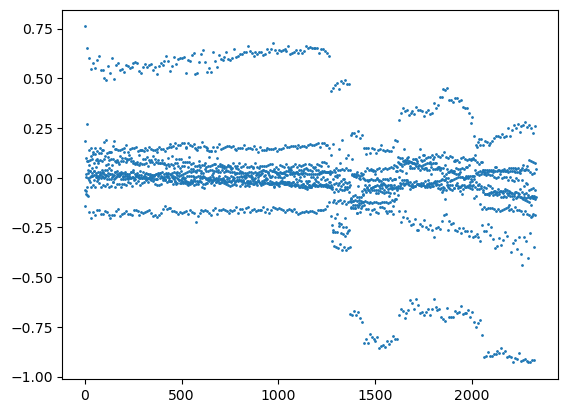

In [32]:
plt.scatter(range(len(image_betas)), image_betas['Beta_Coef'], s=1)

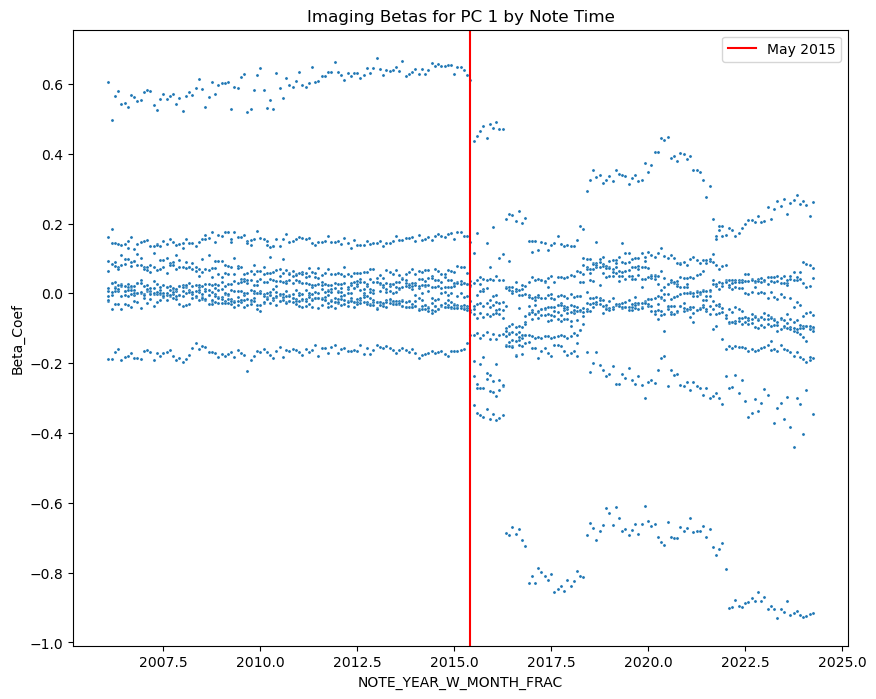

In [62]:
image_betas['NOTE_YEAR_W_MONTH_FRAC'] = image_betas['NOTE_YEAR'] + (1/12)*image_betas['NOTE_MONTH']
plt.figure(figsize=(10,8))
sns.scatterplot(image_betas.loc[(image_betas['NOTE_YEAR'] > 2005)], x='NOTE_YEAR_W_MONTH_FRAC', y='Beta_Coef', s=5).set(title='Imaging Betas for PC 1 by Note Time')
plt.axvline(x=2015 + (5/12), color='red', label='May 2015')
plt.legend(loc='upper right')

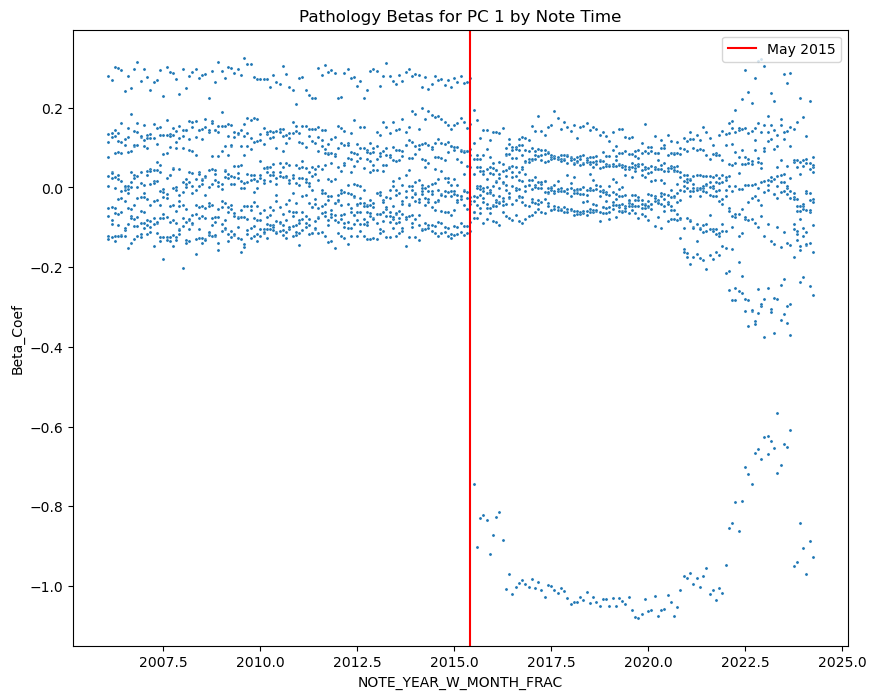

In [61]:
path_betas['NOTE_YEAR'] = path_betas['Dummy_Variable'].apply(lambda x : int(re.split('_', x)[3]))
path_betas['NOTE_MONTH'] = path_betas['Dummy_Variable'].apply(lambda x : int(re.split('_', x)[4]))

path_betas['NOTE_YEAR_W_MONTH_FRAC'] = path_betas['NOTE_YEAR'] + (1/12)*path_betas['NOTE_MONTH']
plt.figure(figsize=(10,8))
sns.scatterplot(path_betas.loc[path_betas['NOTE_YEAR'] > 2005], x='NOTE_YEAR_W_MONTH_FRAC', y='Beta_Coef', s=5).set(title='Pathology Betas for PC 1 by Note Time')
plt.axvline(x=2015 + (5/12), color='red', label='May 2015')
plt.legend(loc='upper right')

In [ ]:
IO_stage_col_sub = pd.get_dummies(IO_stage_entries[['DERIVED_STAGE_MERGED', 'EMBEDDING_INDEX']], columns=['DERIVED_STAGE_MERGED'], drop_first=False)
X = IO_stage_col_sub.drop(columns=['EMBEDDING_INDEX']).astype(int)
embed_idx = IO_stage_col_sub['EMBEDDING_INDEX'].astype(int).tolist()

beta_values = []
score_values = []
for pc_idx in tqdm(list(range(50))):
    lin_model = LinearRegression().fit(X.values, embedding_pcs[embed_idx, pc_idx])
    fit_score = lin_model.score(X.values, embedding_pcs[embed_idx, pc_idx])
    
    beta_values.append(lin_model.coef_)
    score_values.append(fit_score)

### Cancer Stage Association

In [4]:
IO_stage_entries = pd.read_csv(data_path + 'IO_stage_entries.csv', index_col=0)

In [5]:
# test one vs rest for discrete labels
continuous_cols = ['TRUNCATED_SEQ_LEN', 'NOTE_TIME_REL_IO_START']
discrete_cols = ['NOTE_TYPE', 'NOTE_YEAR', 'PROC_DESC', 'PROVIDER_CRED', 'ENCOUNTER_TYPE_DESC', 'DATA_SOURCE', 'PX_CANCER_TYPE', 'PX_EVENT']

discrete_var_map_dict = dict()
discrete_pvalue_dict = dict()
discrete_delta_pc_dict = dict()

min_samples = 100

for col in discrete_cols:
    var_counts = embedding_meta[col].value_counts()
    vars_to_keep = var_counts[var_counts >= min_samples].index.tolist()
    vars_to_collapse = var_counts[var_counts < min_samples].index.tolist()

    if np.sum(embedding_meta[col].isna()) > 0:
        discrete_var_map_dict[col] = {np.nan : np.nan}
    else:
        discrete_var_map_dict[col] = dict()

    discrete_var_map_dict[col].update({var : var for var in vars_to_keep})
    discrete_var_map_dict[col].update({var : np.nan for var in vars_to_collapse})

for col in discrete_cols:
    embedding_meta[col] = embedding_meta[col].map(discrete_var_map_dict[col])

embedding_pcs = PCA(n_components=50).fit_transform(just_embeddings)

clinical_discrete_cols = [col for col in discrete_cols if col not in ['PROC_DESC', 'DATA_SOURCE']]
clinical_meta = embedding_meta.loc[embedding_meta['NOTE_TYPE'] == 'Clinician'].reset_index()
clinical_pcs = PCA(n_components=50).fit_transform(just_embeddings[clinical_meta['EMBEDDING_INDEX'],:])
embed_to_clinical_idx = dict(zip(clinical_meta['EMBEDDING_INDEX'].tolist(), clinical_meta.index.tolist()))

imaging_discrete_cols = [col for col in discrete_cols if col not in ['ENCOUNTER_TYPE_DESC', 'PROVIDER_CRED', 'DATA_SOURCE']]
imaging_meta = embedding_meta.loc[embedding_meta['NOTE_TYPE'] == 'Imaging'].reset_index()
imaging_pcs = PCA(n_components=50).fit_transform(just_embeddings[imaging_meta['EMBEDDING_INDEX'],:])
embed_to_imaging_idx = dict(zip(imaging_meta['EMBEDDING_INDEX'].tolist(), imaging_meta.index.tolist()))

pathology_discrete_cols = imaging_discrete_cols
pathology_meta = embedding_meta.loc[embedding_meta['NOTE_TYPE'] == 'Pathology'].reset_index()
pathology_pcs = PCA(n_components=50).fit_transform(just_embeddings[pathology_meta['EMBEDDING_INDEX'],:])
embed_to_path_idx = dict(zip(pathology_meta['EMBEDDING_INDEX'].tolist(), pathology_meta.index.tolist()))

In [6]:
IO_stage_entries['DERIVED_STAGE_MERGED'] = IO_stage_entries['DERIVED_STAGE_MERGED'].astype(int).astype(str)

In [7]:
IO_stage_col_sub = pd.get_dummies(IO_stage_entries[['DERIVED_STAGE_MERGED', 'EMBEDDING_INDEX']], columns=['DERIVED_STAGE_MERGED'], drop_first=False)
X = IO_stage_col_sub.drop(columns=['EMBEDDING_INDEX']).astype(int)
embed_idx = IO_stage_col_sub['EMBEDDING_INDEX'].astype(int).tolist()

In [8]:
beta_values = []
score_values = []
for pc_idx in tqdm(list(range(50))):
    lin_model = LinearRegression().fit(X.values, embedding_pcs[embed_idx, pc_idx])
    fit_score = lin_model.score(X.values, embedding_pcs[embed_idx, pc_idx])
    
    beta_values.append(lin_model.coef_)
    score_values.append(fit_score)

100%|██████████| 50/50 [00:00<00:00, 75.32it/s]


In [9]:
IO_stage_clinical = IO_stage_col_sub.loc[IO_stage_col_sub['EMBEDDING_INDEX'].isin(embed_to_clinical_idx.keys())]
X = IO_stage_clinical.drop(columns=['EMBEDDING_INDEX']).astype(int)
clin_idx = IO_stage_clinical['EMBEDDING_INDEX'].map(embed_to_clinical_idx).astype(int).tolist()

clin_betas = []
clin_scores = []
for pc_idx in tqdm(list(range(50))):
    lin_model = LinearRegression().fit(X.values, clinical_pcs[clin_idx, pc_idx])
    fit_score = lin_model.score(X.values, clinical_pcs[clin_idx, pc_idx])
    
    clin_betas.append(lin_model.coef_)
    clin_scores.append(fit_score)

100%|██████████| 50/50 [00:00<00:00, 68.68it/s]


In [10]:
IO_stage_image = IO_stage_col_sub.loc[IO_stage_col_sub['EMBEDDING_INDEX'].isin(embed_to_imaging_idx.keys())]
X = IO_stage_image.drop(columns=['EMBEDDING_INDEX']).astype(int)
image_idx = IO_stage_image['EMBEDDING_INDEX'].map(embed_to_imaging_idx).astype(int).tolist()

image_betas = []
image_scores = []
for pc_idx in tqdm(list(range(50))):
    lin_model = LinearRegression().fit(X.values, imaging_pcs[image_idx, pc_idx])
    fit_score = lin_model.score(X.values, imaging_pcs[image_idx, pc_idx])
    
    image_betas.append(lin_model.coef_)
    image_scores.append(fit_score)

100%|██████████| 50/50 [00:00<00:00, 611.08it/s]


In [11]:
IO_stage_path = IO_stage_col_sub.loc[IO_stage_col_sub['EMBEDDING_INDEX'].isin(embed_to_path_idx.keys())]
X = IO_stage_path.drop(columns=['EMBEDDING_INDEX']).astype(int)
path_idx = IO_stage_path['EMBEDDING_INDEX'].map(embed_to_path_idx).astype(int).tolist()

path_betas = []
path_scores = []
for pc_idx in tqdm(list(range(50))):
    lin_model = LinearRegression().fit(X.values, pathology_pcs[path_idx, pc_idx])
    fit_score = lin_model.score(X.values, pathology_pcs[path_idx, pc_idx])
    
    path_betas.append(lin_model.coef_)
    path_scores.append(fit_score)

100%|██████████| 50/50 [00:00<00:00, 866.53it/s]


In [12]:
IO_stage_path

,EMBEDDING_INDEX,DERIVED_STAGE_MERGED_1,DERIVED_STAGE_MERGED_2,DERIVED_STAGE_MERGED_3,DERIVED_STAGE_MERGED_4
1323,313207.0,False,False,False,True
1522,305083.0,False,False,True,False
3210,341478.0,True,False,False,False
5425,351177.0,False,True,False,False
5600,323619.0,False,True,False,False
...,...,...,...,...,...
100458,341959.0,False,False,True,False
102036,338940.0,False,True,False,False
102043,347752.0,False,True,False,False
102683,339076.0,False,False,False,True


In [13]:
results_df = pd.DataFrame({'across_note_type' : score_values, 'clinician_notes' : clin_scores, 
                           'imaging_notes' : image_scores, 'pathology_notes' : path_scores})

[Text(0, 0.5, '0'),
 Text(0, 2.5, '2'),
 Text(0, 4.5, '4'),
 Text(0, 6.5, '6'),
 Text(0, 8.5, '8'),
 Text(0, 10.5, '10'),
 Text(0, 12.5, '12'),
 Text(0, 14.5, '14'),
 Text(0, 16.5, '16'),
 Text(0, 18.5, '18'),
 Text(0, 20.5, '20'),
 Text(0, 22.5, '22'),
 Text(0, 24.5, '24'),
 Text(0, 26.5, '26'),
 Text(0, 28.5, '28'),
 Text(0, 30.5, '30'),
 Text(0, 32.5, '32'),
 Text(0, 34.5, '34'),
 Text(0, 36.5, '36'),
 Text(0, 38.5, '38'),
 Text(0, 40.5, '40'),
 Text(0, 42.5, '42'),
 Text(0, 44.5, '44'),
 Text(0, 46.5, '46'),
 Text(0, 48.5, '48')]

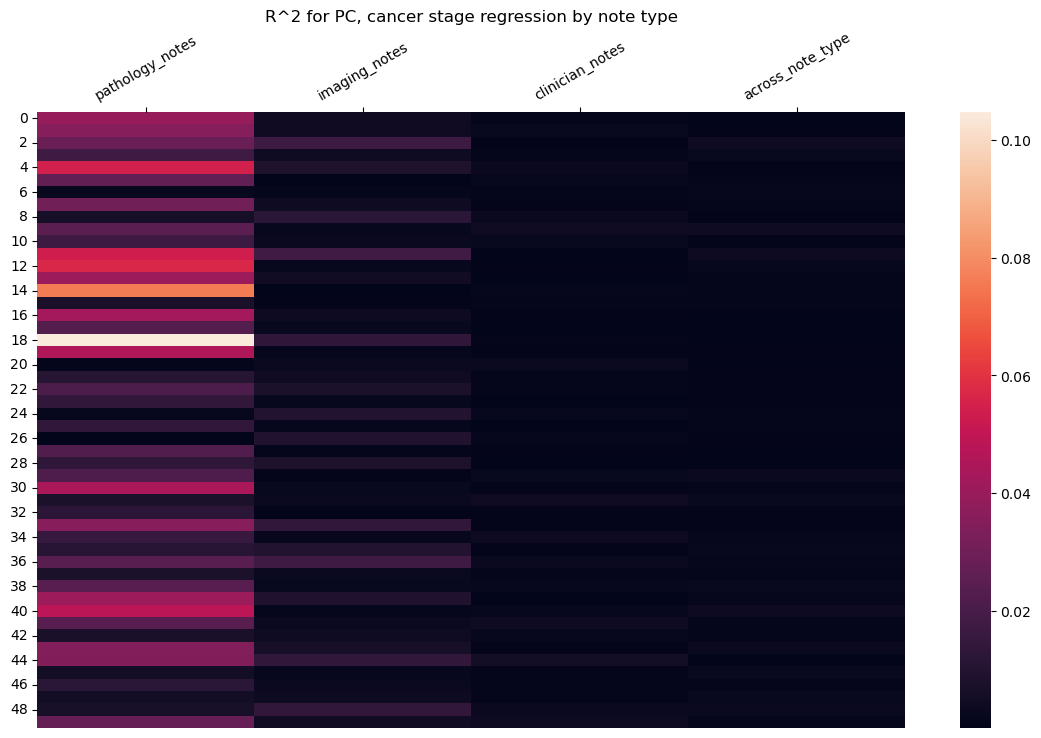

In [14]:
plt.figure(figsize=(14,8))
ax = sns.heatmap(results_df.reindex(results_df.mean().sort_values(ascending=False).index, axis=1))
ax.set(title='R^2 for PC, cancer stage regression by note type')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)